## Załadowanie danych wejściowych

In [1]:
import datasets

print("Loading input data...")

# dataset_names = ["RealTimeData/bbc_news_week1_july_2023"]
dataset_names = ["RealTimeData/bbc_news_may_2023"]
# dataset_names = ["RealTimeData/bbc_news_march_2023", "RealTimeData/bbc_news_april_2023", "RealTimeData/bbc_news_may_2023", "RealTimeData/bbc_news_june_2023", "RealTimeData/bbc_news_july_2023"]

input_data = []
seen_input_links = set()
original_row_count = 0
for dataset_name in dataset_names:
    print("Loading dataset " + dataset_name + "...")

    dataset = datasets.load_dataset(dataset_name, split="train")
    original_row_count += dataset.num_rows

    for row in dataset:
        if row['link'] in seen_input_links:
            continue
        seen_input_links.add(row['link'])
        input_data.append(row)
    
    print(f"Loaded {dataset.num_rows} rows!")
    
print(f"Loaded input data! Rows after dedupe: {len(input_data)}, Original: {original_row_count}")

Loading input data...
Loading dataset RealTimeData/bbc_news_may_2023...
Loaded 1931 rows!
Loaded input data! Rows after dedupe: 1412, Original: 1931


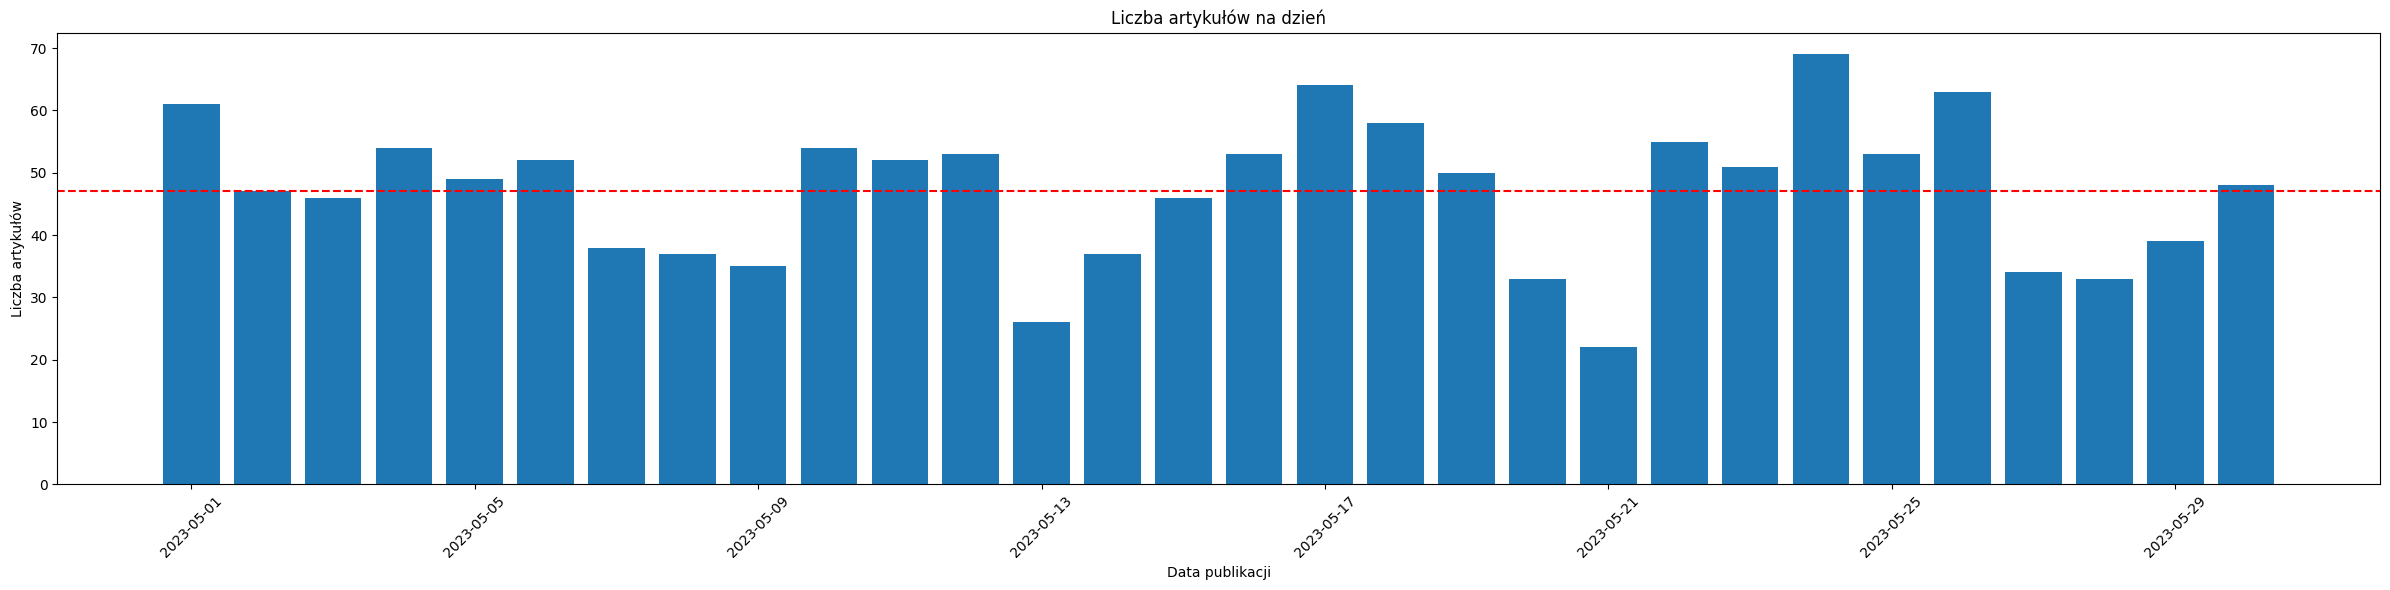

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

article_daily_counts = pd.DataFrame(input_data)['published_date'].dt.date.value_counts().sort_index()


plt.figure(figsize=(24, 6))
plt.bar(article_daily_counts.index, article_daily_counts.values, width=0.8)

plt.axhline(y=article_daily_counts.mean(), color='red', linestyle='--', linewidth=1.5)

plt.xlabel('Data publikacji')
plt.ylabel('Liczba artykułów')
plt.title('Liczba artykułów na dzień')
plt.xticks(rotation=45)
plt.tight_layout()

## Załadowanie modelu do osadzeń

In [3]:
import sentence_transformers
import torch

print("CUDA: {val}".format(val=torch.cuda.is_available()))

# all-MiniLM-L6-v2 (22.7M)
# all-MiniLM-L12-v2 (33M)
# Snowflake/snowflake-arctic-embed-m (109M)
MODEL_NAME = "all-MiniLM-L12-v2"

model = sentence_transformers.SentenceTransformer(MODEL_NAME)


CUDA: True


In [4]:
print("Długość osadzeń: {size}".format(size=model.encode("lorem ipsum", normalize_embeddings=True).size))

Długość osadzeń: 384


## Generowanie osadzeń dla danych wejściowych

In [5]:
input_embeddings = model.encode([row['content'] for row in input_data], normalize_embeddings=True)

## Generowanie osadzeń dla zapytania

In [6]:
MAX_QUERY_RESULTS = 10
QUERY = "Airport"
# Airport, COVID

query_embedding = model.encode(QUERY, normalize_embeddings=True)

## Wyszukiwanie semantyczne

In [7]:
import scipy.spatial.distance as distance
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', None)

def execute_query_with_distance_metric(metric):
    distance_result = distance.cdist([query_embedding], input_embeddings, metric=metric)[0]
        
    top_idx = np.argsort(distance_result)[:MAX_QUERY_RESULTS]
    top_results = [{
        'idx': idx,
        'row': input_data[idx],
        'score': distance_result[idx]
    } for idx in top_idx]

    return top_results

def create_search_results_table_df(search_results, score_label="Wynik"):
    data = [(search_result['idx'], search_result['row']['title'], search_result['row']['section'], search_result['row']['link'], search_result['score']) for search_result in search_results]
    return pd.DataFrame(data, columns=["Idx", "Tytuł", "Sekcja", "Link", score_label])

### Cosine Similarity

In [8]:
cosine_search_results = execute_query_with_distance_metric('cosine')
create_search_results_table_df(cosine_search_results, score_label="Dystans")

,Idx,Tytuł,Sekcja,Link,Dystans
0,247,'Suspected drone' disrupts Gatwick Airport flights - BBC News,Sussex,http://www.bbc.co.uk/news/uk-england-sussex-65591023,0.525758
1,708,Sudan conflict: The Eritrean refugees caught between two crises - BBC News,Africa,http://www.bbc.co.uk/news/world-africa-65637552,0.530571
2,766,Autism: 'Try-before-you-fly scheme lets our holiday go ahead' - BBC News,Northern Ireland,http://www.bbc.co.uk/news/uk-northern-ireland-65624837,0.564290
3,935,Asiana Airlines: Inside cabin as plane door opened mid-flight - BBC News,None,http://www.bbc.co.uk/news/world-asia-65722391,0.569492
4,975,Anger over airports' passport e-gates not working - BBC News,UK,http://www.bbc.co.uk/news/uk-65731795,0.579819
5,951,Asiana Airlines: Passenger arrested for opening plane door during South Korea flight - BBC News,Asia,http://www.bbc.co.uk/news/world-asia-65705276,0.596977
6,43,Sudan: Extra rescue flight for British nationals - BBC News,UK,http://www.bbc.co.uk/news/uk-65441191,0.597397
7,959,Scottish airports warning as e-gates not working - BBC News,Scotland,http://www.bbc.co.uk/news/uk-scotland-65732795,0.611902
8,861,British Airways cancels 43 flights due to another IT issue - BBC News,Business,http://www.bbc.co.uk/news/business-65713903,0.617464
9,982,China's C919 passenger plane enters into service - BBC News,China,http://www.bbc.co.uk/news/world-asia-china-65737081,0.623828


### Euclidean Distance

In [9]:
euclidean_search_results = execute_query_with_distance_metric('euclidean')
create_search_results_table_df(euclidean_search_results, score_label="Dystans")

,Idx,Tytuł,Sekcja,Link,Dystans
0,247,'Suspected drone' disrupts Gatwick Airport flights - BBC News,Sussex,http://www.bbc.co.uk/news/uk-england-sussex-65591023,1.025434
1,708,Sudan conflict: The Eritrean refugees caught between two crises - BBC News,Africa,http://www.bbc.co.uk/news/world-africa-65637552,1.030118
2,766,Autism: 'Try-before-you-fly scheme lets our holiday go ahead' - BBC News,Northern Ireland,http://www.bbc.co.uk/news/uk-northern-ireland-65624837,1.062346
3,935,Asiana Airlines: Inside cabin as plane door opened mid-flight - BBC News,None,http://www.bbc.co.uk/news/world-asia-65722391,1.067232
4,975,Anger over airports' passport e-gates not working - BBC News,UK,http://www.bbc.co.uk/news/uk-65731795,1.076865
5,951,Asiana Airlines: Passenger arrested for opening plane door during South Korea flight - BBC News,Asia,http://www.bbc.co.uk/news/world-asia-65705276,1.092682
6,43,Sudan: Extra rescue flight for British nationals - BBC News,UK,http://www.bbc.co.uk/news/uk-65441191,1.093066
7,959,Scottish airports warning as e-gates not working - BBC News,Scotland,http://www.bbc.co.uk/news/uk-scotland-65732795,1.106257
8,861,British Airways cancels 43 flights due to another IT issue - BBC News,Business,http://www.bbc.co.uk/news/business-65713903,1.111273
9,982,China's C919 passenger plane enters into service - BBC News,China,http://www.bbc.co.uk/news/world-asia-china-65737081,1.116985


### Manhattan Distance

In [10]:
manhattan_search_results = execute_query_with_distance_metric('cityblock')
create_search_results_table_df(manhattan_search_results, score_label="Dystans")

,Idx,Tytuł,Sekcja,Link,Dystans
0,708,Sudan conflict: The Eritrean refugees caught between two crises - BBC News,Africa,http://www.bbc.co.uk/news/world-africa-65637552,15.575636
1,247,'Suspected drone' disrupts Gatwick Airport flights - BBC News,Sussex,http://www.bbc.co.uk/news/uk-england-sussex-65591023,15.853619
2,935,Asiana Airlines: Inside cabin as plane door opened mid-flight - BBC News,None,http://www.bbc.co.uk/news/world-asia-65722391,16.467948
3,766,Autism: 'Try-before-you-fly scheme lets our holiday go ahead' - BBC News,Northern Ireland,http://www.bbc.co.uk/news/uk-northern-ireland-65624837,16.579944
4,861,British Airways cancels 43 flights due to another IT issue - BBC News,Business,http://www.bbc.co.uk/news/business-65713903,16.799748
5,975,Anger over airports' passport e-gates not working - BBC News,UK,http://www.bbc.co.uk/news/uk-65731795,16.801055
6,43,Sudan: Extra rescue flight for British nationals - BBC News,UK,http://www.bbc.co.uk/news/uk-65441191,16.927885
7,959,Scottish airports warning as e-gates not working - BBC News,Scotland,http://www.bbc.co.uk/news/uk-scotland-65732795,17.035494
8,951,Asiana Airlines: Passenger arrested for opening plane door during South Korea flight - BBC News,Asia,http://www.bbc.co.uk/news/world-asia-65705276,17.064466
9,982,China's C919 passenger plane enters into service - BBC News,China,http://www.bbc.co.uk/news/world-asia-china-65737081,17.483274


### Correlation

In [11]:
correlation_search_results = execute_query_with_distance_metric('correlation')
create_search_results_table_df(correlation_search_results, score_label="Dystans")

,Idx,Tytuł,Sekcja,Link,Dystans
0,247,'Suspected drone' disrupts Gatwick Airport flights - BBC News,Sussex,http://www.bbc.co.uk/news/uk-england-sussex-65591023,0.525242
1,708,Sudan conflict: The Eritrean refugees caught between two crises - BBC News,Africa,http://www.bbc.co.uk/news/world-africa-65637552,0.529710
2,766,Autism: 'Try-before-you-fly scheme lets our holiday go ahead' - BBC News,Northern Ireland,http://www.bbc.co.uk/news/uk-northern-ireland-65624837,0.562897
3,935,Asiana Airlines: Inside cabin as plane door opened mid-flight - BBC News,None,http://www.bbc.co.uk/news/world-asia-65722391,0.569905
4,975,Anger over airports' passport e-gates not working - BBC News,UK,http://www.bbc.co.uk/news/uk-65731795,0.579367
5,951,Asiana Airlines: Passenger arrested for opening plane door during South Korea flight - BBC News,Asia,http://www.bbc.co.uk/news/world-asia-65705276,0.596526
6,43,Sudan: Extra rescue flight for British nationals - BBC News,UK,http://www.bbc.co.uk/news/uk-65441191,0.596792
7,959,Scottish airports warning as e-gates not working - BBC News,Scotland,http://www.bbc.co.uk/news/uk-scotland-65732795,0.610899
8,861,British Airways cancels 43 flights due to another IT issue - BBC News,Business,http://www.bbc.co.uk/news/business-65713903,0.617040
9,982,China's C919 passenger plane enters into service - BBC News,China,http://www.bbc.co.uk/news/world-asia-china-65737081,0.623326


### Średni wynik

In [12]:
def merge_search_results(search_results_sets):
    article_idx_to_score_sum = dict()

    for search_results in search_results_sets:
        for i in range(len(search_results)):
            row_idx = search_results[i]['idx']
            if row_idx not in article_idx_to_score_sum:
                article_idx_to_score_sum[row_idx] = 0
            # 1st place = MAX_QUERY_RESULTS points
            # last place = 1 point
            article_idx_to_score_sum[row_idx] += MAX_QUERY_RESULTS-i

    merged_search_results = [{
        'idx': article_idx,
        'row': input_data[article_idx],
        'score': score_sum
    } for article_idx, score_sum in article_idx_to_score_sum.items()]
    merged_search_results.sort(key=lambda search_result: search_result['score'], reverse=True)
    merged_search_results = merged_search_results[:MAX_QUERY_RESULTS]

    return merged_search_results

semantic_average_search_results = merge_search_results([cosine_search_results, euclidean_search_results, manhattan_search_results, correlation_search_results])
create_search_results_table_df(semantic_average_search_results)

,Idx,Tytuł,Sekcja,Link,Wynik
0,247,'Suspected drone' disrupts Gatwick Airport flights - BBC News,Sussex,http://www.bbc.co.uk/news/uk-england-sussex-65591023,39
1,708,Sudan conflict: The Eritrean refugees caught between two crises - BBC News,Africa,http://www.bbc.co.uk/news/world-africa-65637552,37
2,766,Autism: 'Try-before-you-fly scheme lets our holiday go ahead' - BBC News,Northern Ireland,http://www.bbc.co.uk/news/uk-northern-ireland-65624837,31
3,935,Asiana Airlines: Inside cabin as plane door opened mid-flight - BBC News,None,http://www.bbc.co.uk/news/world-asia-65722391,29
4,975,Anger over airports' passport e-gates not working - BBC News,UK,http://www.bbc.co.uk/news/uk-65731795,23
5,951,Asiana Airlines: Passenger arrested for opening plane door during South Korea flight - BBC News,Asia,http://www.bbc.co.uk/news/world-asia-65705276,17
6,43,Sudan: Extra rescue flight for British nationals - BBC News,UK,http://www.bbc.co.uk/news/uk-65441191,16
7,959,Scottish airports warning as e-gates not working - BBC News,Scotland,http://www.bbc.co.uk/news/uk-scotland-65732795,12
8,861,British Airways cancels 43 flights due to another IT issue - BBC News,Business,http://www.bbc.co.uk/news/business-65713903,12
9,982,China's C919 passenger plane enters into service - BBC News,China,http://www.bbc.co.uk/news/world-asia-china-65737081,4


## Wyszukiwanie tekstowe

### TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(row['content'] for row in input_data)

In [14]:

tfidf_query_vector = tfidf_vectorizer.transform([QUERY])
tfidf_similarities = cosine_similarity(tfidf_query_vector, tfidf_matrix).flatten()
tfidf_top_idx = np.argsort(tfidf_similarities)[::-1][:MAX_QUERY_RESULTS]

tfidf_search_results = []
for idx in tfidf_top_idx:
    score = tfidf_similarities[idx]
    if score <= 0:
        continue
    tfidf_search_results.append({
        'idx': idx,
        'row': input_data[idx],
        'score': tfidf_similarities[idx]
    })

create_search_results_table_df(tfidf_search_results, score_label="Wynik (TF-IDF)")

,Idx,Tytuł,Sekcja,Link,Wynik (TF-IDF)
0,1374,"Powys: Spoof £25,000 airport sign makes a welcome return - BBC News",Wales,http://www.bbc.co.uk/news/uk-wales-65501398,0.356693
1,766,Autism: 'Try-before-you-fly scheme lets our holiday go ahead' - BBC News,Northern Ireland,http://www.bbc.co.uk/news/uk-northern-ireland-65624837,0.301046
2,975,Anger over airports' passport e-gates not working - BBC News,UK,http://www.bbc.co.uk/news/uk-65731795,0.265379
3,247,'Suspected drone' disrupts Gatwick Airport flights - BBC News,Sussex,http://www.bbc.co.uk/news/uk-england-sussex-65591023,0.258973
4,959,Scottish airports warning as e-gates not working - BBC News,Scotland,http://www.bbc.co.uk/news/uk-scotland-65732795,0.184172
5,708,Sudan conflict: The Eritrean refugees caught between two crises - BBC News,Africa,http://www.bbc.co.uk/news/world-africa-65637552,0.168921
6,1118,Watch: Police find marijuana stash in church-owned plane - BBC News,None,http://www.bbc.co.uk/news/world-latin-america-65759925,0.155999
7,794,Coventry gigafactory: JLR owner's plans disappointing - mayor - BBC News,Coventry & Warwickshire,http://www.bbc.co.uk/news/uk-england-coventry-warwickshire-64824456,0.153073
8,1009,Melissa Kinsella: Mum left in coma in Turkey dies after UK return - BBC News,Liverpool,http://www.bbc.co.uk/news/uk-england-merseyside-65737680,0.135657
9,677,Mexican volcano spews smoke into starry sky - BBC News,None,http://www.bbc.co.uk/news/world-latin-america-65671578,0.131924


### BM25

In [15]:
from rank_bm25 import BM25Okapi
import re

def bm25_preprocess(text):
    return re.findall(r'\b\w+\b', text.lower())

bm25_index = BM25Okapi([bm25_preprocess(row['content']) for row in input_data])

In [16]:
bm25_scores = list(enumerate(bm25_index.get_scores(bm25_preprocess(QUERY))))
bm25_scores.sort(key=lambda x: x[1], reverse=True)
bm25_scores = bm25_scores[:MAX_QUERY_RESULTS]

bm25_search_results = []
for idx, score in bm25_scores:
    if score <= 0:
        continue
    bm25_search_results.append({
        'idx': idx,
        'row': input_data[idx],
        'score': score
    })

create_search_results_table_df(bm25_search_results, score_label="Wynik (BM25)")

,Idx,Tytuł,Sekcja,Link,Wynik (BM25)
0,1374,"Powys: Spoof £25,000 airport sign makes a welcome return - BBC News",Wales,http://www.bbc.co.uk/news/uk-wales-65501398,7.826596
1,766,Autism: 'Try-before-you-fly scheme lets our holiday go ahead' - BBC News,Northern Ireland,http://www.bbc.co.uk/news/uk-northern-ireland-65624837,7.744392
2,247,'Suspected drone' disrupts Gatwick Airport flights - BBC News,Sussex,http://www.bbc.co.uk/news/uk-england-sussex-65591023,7.744288
3,975,Anger over airports' passport e-gates not working - BBC News,UK,http://www.bbc.co.uk/news/uk-65731795,7.486928
4,959,Scottish airports warning as e-gates not working - BBC News,Scotland,http://www.bbc.co.uk/news/uk-scotland-65732795,7.013667
5,708,Sudan conflict: The Eritrean refugees caught between two crises - BBC News,Africa,http://www.bbc.co.uk/news/world-africa-65637552,6.903564
6,794,Coventry gigafactory: JLR owner's plans disappointing - mayor - BBC News,Coventry & Warwickshire,http://www.bbc.co.uk/news/uk-england-coventry-warwickshire-64824456,6.642957
7,1009,Melissa Kinsella: Mum left in coma in Turkey dies after UK return - BBC News,Liverpool,http://www.bbc.co.uk/news/uk-england-merseyside-65737680,6.303557
8,1118,Watch: Police find marijuana stash in church-owned plane - BBC News,None,http://www.bbc.co.uk/news/world-latin-america-65759925,6.177748
9,677,Mexican volcano spews smoke into starry sky - BBC News,None,http://www.bbc.co.uk/news/world-latin-america-65671578,6.102755


### Średni wynik

In [17]:
full_text_average_search_results = merge_search_results([tfidf_search_results, bm25_search_results])
create_search_results_table_df(full_text_average_search_results)

,Idx,Tytuł,Sekcja,Link,Wynik
0,1374,"Powys: Spoof £25,000 airport sign makes a welcome return - BBC News",Wales,http://www.bbc.co.uk/news/uk-wales-65501398,20
1,766,Autism: 'Try-before-you-fly scheme lets our holiday go ahead' - BBC News,Northern Ireland,http://www.bbc.co.uk/news/uk-northern-ireland-65624837,18
2,975,Anger over airports' passport e-gates not working - BBC News,UK,http://www.bbc.co.uk/news/uk-65731795,15
3,247,'Suspected drone' disrupts Gatwick Airport flights - BBC News,Sussex,http://www.bbc.co.uk/news/uk-england-sussex-65591023,15
4,959,Scottish airports warning as e-gates not working - BBC News,Scotland,http://www.bbc.co.uk/news/uk-scotland-65732795,12
5,708,Sudan conflict: The Eritrean refugees caught between two crises - BBC News,Africa,http://www.bbc.co.uk/news/world-africa-65637552,10
6,794,Coventry gigafactory: JLR owner's plans disappointing - mayor - BBC News,Coventry & Warwickshire,http://www.bbc.co.uk/news/uk-england-coventry-warwickshire-64824456,7
7,1118,Watch: Police find marijuana stash in church-owned plane - BBC News,None,http://www.bbc.co.uk/news/world-latin-america-65759925,6
8,1009,Melissa Kinsella: Mum left in coma in Turkey dies after UK return - BBC News,Liverpool,http://www.bbc.co.uk/news/uk-england-merseyside-65737680,5
9,677,Mexican volcano spews smoke into starry sky - BBC News,None,http://www.bbc.co.uk/news/world-latin-america-65671578,2


## Wyszukiwanie hybrydowe

In [18]:
semantic_fulltext_merged_average_search_results = merge_search_results([semantic_average_search_results, full_text_average_search_results])
create_search_results_table_df(semantic_fulltext_merged_average_search_results)

,Idx,Tytuł,Sekcja,Link,Wynik
0,247,'Suspected drone' disrupts Gatwick Airport flights - BBC News,Sussex,http://www.bbc.co.uk/news/uk-england-sussex-65591023,17
1,766,Autism: 'Try-before-you-fly scheme lets our holiday go ahead' - BBC News,Northern Ireland,http://www.bbc.co.uk/news/uk-northern-ireland-65624837,17
2,708,Sudan conflict: The Eritrean refugees caught between two crises - BBC News,Africa,http://www.bbc.co.uk/news/world-africa-65637552,14
3,975,Anger over airports' passport e-gates not working - BBC News,UK,http://www.bbc.co.uk/news/uk-65731795,14
4,1374,"Powys: Spoof £25,000 airport sign makes a welcome return - BBC News",Wales,http://www.bbc.co.uk/news/uk-wales-65501398,10
5,959,Scottish airports warning as e-gates not working - BBC News,Scotland,http://www.bbc.co.uk/news/uk-scotland-65732795,9
6,935,Asiana Airlines: Inside cabin as plane door opened mid-flight - BBC News,None,http://www.bbc.co.uk/news/world-asia-65722391,7
7,951,Asiana Airlines: Passenger arrested for opening plane door during South Korea flight - BBC News,Asia,http://www.bbc.co.uk/news/world-asia-65705276,5
8,43,Sudan: Extra rescue flight for British nationals - BBC News,UK,http://www.bbc.co.uk/news/uk-65441191,4
9,794,Coventry gigafactory: JLR owner's plans disappointing - mayor - BBC News,Coventry & Warwickshire,http://www.bbc.co.uk/news/uk-england-coventry-warwickshire-64824456,4


# Analiza sentymentu na bazie kategorii artykułu

In [19]:
import transformers
import warnings

warnings.filterwarnings('ignore')

# distilbert/distilbert-base-uncased-finetuned-sst-2-english
# lxyuan/distilbert-base-multilingual-cased-sentiments-student

pipeline_sentiment_analysis = transformers.pipeline("sentiment-analysis", model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")
sentiment_analysis_results = pipeline_sentiment_analysis([row['title'] for row in input_data])

pd.DataFrame([(input_data[i]['title'], input_data[i]['section'], sentiment_analysis_results[i]['label'], sentiment_analysis_results[i]['score']) for i in range(len(input_data))[:20]], columns=["Tytuł", "Sekcja", "Sentyment", "Wynik"])

Device set to use cuda:0


,Tytuł,Sekcja,Sentyment,Wynik
0,Photo of smiling Princess Charlotte shared as she turns 8 - BBC News,UK,positive,0.585932
1,Ukraine war: Bakhmut defenders worry about losing support - BBC News,Europe,negative,0.581793
2,Ukraine war: Leak shows Western special forces on the ground - BBC News,Europe,positive,0.466686
3,Coronation: Military rehearse parade on replica route - BBC News,UK,positive,0.712760
4,UK chip giant Arm files for blockbuster US share listing - BBC News,Business,positive,0.501894
5,Caerphilly: Baby in hospital after dog attack - BBC News,Wales,positive,0.510772
6,"Jock Zonfrillo: MasterChef Australia host dies suddenly, aged 46 - BBC News",Australia,positive,0.473475
7,Sudan crisis: Chaos at port as thousands rush to leave - BBC News,Africa,negative,0.818825
8,Bulgari store in Paris robbed in broad daylight - BBC News,None,negative,0.704363
9,Sudan fighting: Why it matters to countries worldwide - BBC News,Africa,negative,0.563437


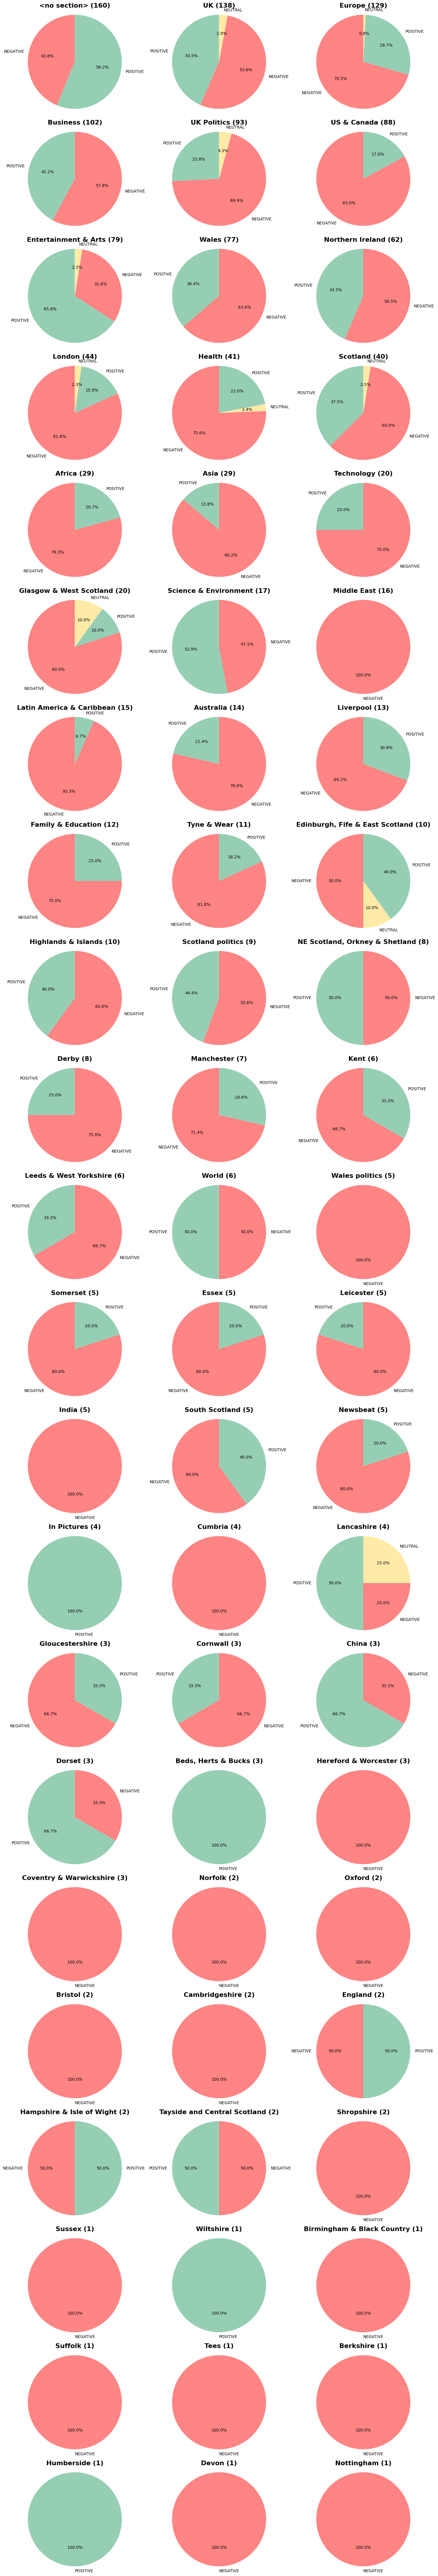

In [20]:
import matplotlib.pyplot as plt

section_to_label_to_count = {}
for i in range(len(sentiment_analysis_results)):
    section = input_data[i]['section']
    if section == None:
        section = "<no section>"

    if section not in section_to_label_to_count:
        section_to_label_to_count[section] = {}
    label_to_count = section_to_label_to_count[section]

    label = sentiment_analysis_results[i]['label']
    if label not in label_to_count:
        label_to_count[label] = 0
    label_to_count[label]+=1

charts_count = len(section_to_label_to_count)
col_count = min(3,charts_count )
row_count = (charts_count + col_count - 1) // col_count

fig, axes = plt.subplots(row_count, col_count)
fig.set_size_inches(5*col_count, 4*row_count)
axes = axes.flatten()

sections_sorted = sorted(section_to_label_to_count.keys(), key=lambda section: sum(section_to_label_to_count[section].values()), reverse=True)

i = 0
for section in sections_sorted:
    pie_labels = []
    pie_values = []
    pie_colors = []

    total_count = 0
    label_to_count = section_to_label_to_count[section]
    for label in label_to_count:
        count = label_to_count[label]
        total_count += count

        label_formatted = label.upper()

        pie_labels.append(label_formatted)
        pie_values.append(count)
        if label_formatted == "POSITIVE":
            pie_colors.append("#96CEB4")
        elif label_formatted == "NEGATIVE":
            pie_colors.append("#FF8484")
        else:
            pie_colors.append("#FFEAA7")

    axis = axes[i]
    axis.pie(pie_values, labels=pie_labels, colors=pie_colors, autopct='%1.1f%%', startangle=90)
    axis.set_title(f"{section} ({total_count})", fontweight="bold", fontsize=16)
    axis.axis('equal')
    i+=1

for i in range(charts_count, len(axes)):
    axes[i].axis('off')

plt.style.use('default')
plt.tight_layout()